# Homework Lecture 4

This homework problem focuses on Lasso. As an example, we are going to use [McCracken's Monthly and Quarterly Databases for Macroeconomic Research](https://research.stlouisfed.org/econ/mccracken/fred-databases/). The databases offer real-time vintages on many US macroeconomic variables. For those of you who are not familiar, there is an important difference (among other things) between, e.g., financial market data and macroeconomic data. Data on stock prices for example is almost immediately available and "fixed". It is simple a snapshot of stock market prices at a given point in time. Macroeconomic indicators such as GDP, however, are complicated and costly to compile. They are estimates of the true economic activity and often revised sometimes even years later when new data comes in. Thus past values are subject to change. A so-called data vintage is the current value of the series that is available at that point in time (but might be revised later). A real-time database stores all of these values and thus allows to monitor how a given estimate of, e.g., GDP might have changed over time. Macroeconomic forecasting models that only use real-time data (data that would have been available/known in the past at the time a specific forecast was made) are hence called real-time forecasting models.  

For our small exercise we are going to focus on the current vintage. This means that we are going to use the data is available right now. We are going to focus on the monthly dataset here. Let's pretend that we are interested in predicting inflation. 

I choose this dataset since it offers many features and provides quite a long time-series. In the second tutorial, we are going to look at the quarterly data-set instead. 

### 1.0 Setup

In [1]:
# import Python packages
%matplotlib inline  
import pandas as pd 
import numpy as np  
import scipy as sp 
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce
from IPython.display import Image
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size

### 2.0 Data & Data Cleaning

In [2]:
# read-in the .csv file
df = pd.read_csv('current_M.csv')

# store the transformation information for later
df_transform = df.iloc[0,:]

# delete the first row as they contain meta-information
df = df.iloc[1:,:]

# transform the date series into datetime values
df['sasdate'] = df['sasdate'].astype('datetime64[ns]') 

# set the dates as new index
df = df.set_index('sasdate')

# display the data 
df.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6250,23.4581,22.1904,32.4078,21.9882,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1959-02-01,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0681,23.7747,22.3827,32.6455,22.1036,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
1959-03-01,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4004,23.9186,22.4925,32.6455,22.5365,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
1959-04-01,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8989,24.2641,22.8221,33.1606,22.6807,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
1959-05-01,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2589,24.4655,23.0418,33.3190,23.1424,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


The dataframe now includes the raw data. You might have notices the row `transform` that I save in variable `df_transform`. It contains numbers from 1 to 7 that denote a method of transformation that is suggested for the specific type of data. As a slight digression from the homework problem, I will apply these transformations instead of simply differencing all the data. As a bonus, we will be able to recycle a lot of the following code for the second tutorial! 

In [3]:
# create an emptyh copy of the dataframe, where the indices and column names are the same
df_trans = pd.DataFrame(index=df.index, columns=df.columns)

# loop over the columns of the dataframe 
for i in range(0,df.shape[1]):
    
    # transform data to 'levels', i.e. no change
    if df_transform[i+1] == 1:
        df_trans[df.columns[i]] = df[df.columns[i]]
    
    # transform data to 'first differences'
    elif df_transform[i+1] == 2:
        df_trans[df.columns[i]] = df[df.columns[i]].diff()
    
    # transform data to 'second differences'
    elif df_transform[i+1] == 3:
        df_trans[df.columns[i]] = df[df.columns[i]].diff(periods=2)
        
    # transform data to 'log-levels'
    elif df_transform[i+1] == 4:
        df_trans[df.columns[i]] = np.log(df[df.columns[i]])
        
    # transform data to 'log-differences'
    elif df_transform[i+1] == 5:
        df_trans[df.columns[i]] = np.log(df[df.columns[i]]).diff()
    
    # transform data to 'second log-differences'
    elif df_transform[i+1] == 6:
        df_trans[df.columns[i]] = np.log(df[df.columns[i]]).diff(periods=2)
    
    # transform data to 'percentage changes'
    elif df_transform[i+1] == 7:
        df_trans[df.columns[i]] = df[df.columns[i]].pct_change()

# display the transformed data
df_trans.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,0.003934,0.003576,0.010350,0.007400,0.007310,0.019395,0.013406,0.008629,0.007308,0.005235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,0.006431,0.007374,0.009394,-0.003416,0.008321,0.014302,0.006034,0.004894,0.000000,0.019396,...,0.003252,0.009346,0.000000,0.014599,NaN,0.009053,0.004929,0.004138,-0.030921,NaN
1959-04-01,0.006498,0.007019,-0.003576,0.019929,0.000616,0.021079,0.014341,0.014547,0.015655,0.006378,...,0.005348,0.009302,0.004057,0.014528,NaN,0.007580,0.021992,0.015011,-0.020784,NaN
1959-05-01,0.005826,0.006629,0.011984,0.006796,0.007803,0.014951,0.008266,0.009581,0.004765,0.020152,...,0.005164,0.009259,0.012171,0.004819,NaN,0.009686,0.036955,0.023766,-0.011197,NaN


Due to differencing the data, we lost observations. Moreover, the dataset contains a row of missing values at the end of the sample. We will also delete this row. To make the process more efficient, we can utilize logical operators that return Boolean values. I am not using .dropna() here, because the data might contain time series that start only later in the sample. Dropping all rows containing NaNs, would thus reduce the sample size. Since more elaborate techniques of dealing with missing data are beyond the scope of this course, we will simply drop these variables from our set. For that we can use .dropna(axis = 1). 

As a word of caution, sometimes data series are subject to so-called publication lags. This means that the value of a time-series for e.g. January 2021 might only be available at a later point in time, e.g. February or March. Reasons for this can be related to the process of compiling certain time-series that can be quite demanding for the statistics agencies that are involved. Thus, additional missing values can result at the end of the sample for certain variables. The resulting "bumpy" pattern at the bottom om the sample is also referred to as "ragged-edge" (for those of you who are interested). Many techniques exist for dealing with this phenomenon, most of which are too complex for this course. To keep things simple, we will simply drop an additional row. Variables that have longer publication lags will simply be dropped in the process of calling `.dropna(axis = 1)`. 

In [4]:
# here I simply use the df_transform series and the fact that Python reads if statements from top to bottom.
# Checking for two missing values must hence be done first.

# check whether the transformation code contains 2nd differences or 2nd log-differences
if 3 in df_transform.unique() or 6 in df_transform.unique():
    
    # print a message
    print('two missing values at the beginning detected. Deleted the first two rows.')
    # drop the first two observations
    df_trans = df_trans.iloc[2:,:]

# check whether the transformation code contains 1st differences or 1st log-differences or pct. changes
elif 2 in df_transform.unique() or 5 in df_transform.unique() or 7 in df_transform.unique():
    
    # print a meassage
    print('one missing values at the beginning detected. Deleted the first row.')
    
    # drop the first observation
    df_trans = df_trans.iloc[1:,:]

# drop missing values at the end of the sample     
df_trans = df_trans.iloc[:-2,:]

df_trans

two missing values at the beginning detected. Deleted the first two rows.


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-03-01,0.006431,0.007374,0.009394,-0.003416,0.008321,0.014302,0.006034,0.004894,0.000000,0.019396,...,0.003252,0.009346,0.000000,0.014599,NaN,0.009053,0.004929,0.004138,-0.030921,NaN
1959-04-01,0.006498,0.007019,-0.003576,0.019929,0.000616,0.021079,0.014341,0.014547,0.015655,0.006378,...,0.005348,0.009302,0.004057,0.014528,NaN,0.007580,0.021992,0.015011,-0.020784,NaN
1959-05-01,0.005826,0.006629,0.011984,0.006796,0.007803,0.014951,0.008266,0.009581,0.004765,0.020152,...,0.005164,0.009259,0.012171,0.004819,NaN,0.009686,0.036955,0.023766,-0.011197,NaN
1959-06-01,0.003108,0.003022,0.003646,-0.000027,0.009064,0.001141,0.007034,0.007127,-0.004765,0.007456,...,0.005233,0.004619,0.012073,0.004796,NaN,0.013572,0.049509,0.034793,-0.038791,NaN
1959-07-01,-0.000586,-0.000808,-0.003365,0.012104,-0.000330,-0.024239,0.001168,0.008248,0.013056,0.019609,...,0.007220,0.000000,0.012024,0.004796,NaN,0.010654,0.054605,0.042800,-0.021701,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,-0.015527,0.015628,0.057608,0.068793,0.082043,0.060489,0.070526,0.084181,0.082358,0.352332,...,0.004793,0.007117,0.023116,-0.004853,5.8,0.066226,0.043321,0.009786,0.043961,30.0744
2020-07-01,0.006336,0.014149,0.012139,0.022510,0.011185,0.040973,0.042236,0.047744,0.044728,0.158251,...,0.004006,0.001967,0.011327,0.002634,-5.6,0.016776,0.041755,0.011547,0.064834,24.3785
2020-08-01,-0.029106,0.012005,0.009006,0.002694,0.013863,0.007524,0.010738,0.010721,0.007076,-0.007084,...,0.004164,0.003932,0.002044,0.009683,1.6,0.006424,0.030268,0.009663,0.043334,20.2777


In [5]:
# drop columns with missing values
df_trans = df_trans.dropna(1)
print('remaining number of variables: ' + str(df_trans.shape[1]))

remaining number of variables: 115


With our dataset prepared in such a way, we can now proceed with the analysis.

### 3.0 Estimation
A couple of remarks are in order before we jump into estimating the Lasso.
* We need to split the data in half (demanded by the exercise)
* We need to construct X and Y. Since X is lagged, we are going to loose another observation.
* For reasons outlined in tutorial 2:
    * We are going to standardize the data
    * We are going to use the `Scikit-learn` toolbox

Note that doing the steps in the order below avoids doing the same work multiple times. 


#### 3.1 Constructing X and Y

As mentioned before, our objective is to predict inflation. Using the [Guide](https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/Appendix_Tables_Update.pdf), we simply need to find the data label for inflation (since we dropped a few variables, the `id` is no longer of use). In this dataset, we have the choice between `CPI` (Consumer Price Index) or `PCE` (Personal Consumption Expenditure). The former is a widely used inflation index, while the latter is the inflation index targeted by the "FED". Let's hence pretend that we are central bankers and target the latter. Since the data also contains sub-aggregates of `PCE`, I am going to drop them as well. This way we only use data is not directly contained in the variables itself.

In [6]:
# read out Y
Y = np.asarray(df_trans['PCEPI'])
Y = Y[1:]

# read out X
X = np.asarray(df_trans.drop(['PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA'], axis=1))
X = X[:-1,:]

#### 3.2 Splitting the sample in half

We split the sample in half as the second step since this assures that we maintain the structure of `X` and `Y`.

In [7]:
# number of samples
k = 2

# generate arrays containing the indices of the 2 data chunks
ids = list(range(len(Y)))
chunks = np.asarray(np.array_split(np.array(ids),k), dtype=object)

# read out the sample size
n = list(range(len(Y)))

# convert k into a list
a = np.arange(k)

# obtain the indeces of the data belonging to the training sample
b_train = a[np.arange(len(a))!=1]
subid_train = np.concatenate( chunks[b_train], axis=0 )

# obtain the indices of the data belonging to the test sample
b_test =  a[np.arange(len(a)) ==1]
subid_test = np.concatenate( chunks[b_test], axis=0 )

# devide the data into test and training samples
Y1 = Y[subid_train]
X1 = X[subid_train,:]
Y2 = Y[subid_test]
X2 = X[subid_test,:]

#### 3.3 Standardize the data

Note that this step comes last. The samples could have different means and variances so we should treat them like this. 

In [8]:
from sklearn.preprocessing import StandardScaler

# initialize the class
Y1_std = StandardScaler()
Y2_std = StandardScaler()
X1_std = StandardScaler()
X2_std = StandardScaler()

# compute mean and std. used for computing the z-score
Y1_std.fit(Y1[:,None])
Y2_std.fit(Y2[:,None])
X1_std.fit(X1)
X2_std.fit(X2)

# transform the data 
Y1_std = Y1_std.transform(Y1[:,None])
Y2_std = Y2_std.transform(Y2[:,None])
X1_std = X1_std.transform(X1)
X2_std = X2_std.transform(X2)

With these steps completed, we can now finally jump into the estimation.

#### 3.4 Lasso

As mentioned above, we are going to use `scikit-learn`'s [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html).

##### 3.4.1 Sample 1

In [9]:
# import Lasso with cross-validation
from sklearn.linear_model import LassoCV

# define the LassoCV object
Lasso = LassoCV(cv=5, fit_intercept=False, normalize=False).fit(X1_std, Y1_std.ravel())
print('The optimal alpha is: '+ str(Lasso.alpha_))

The optimal alpha is: 0.02161448684973626


Let us look at the paths for the coefficients.

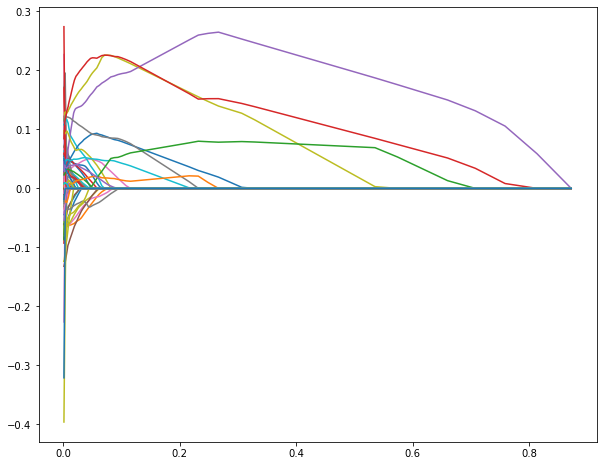

In [10]:
# compute the path
[alphas,weights,c] = Lasso.path(X1_std, Y1_std.ravel())

# plot the path
fig, ax = plt.subplots()
ax.plot(alphas, weights.T)
plt.show()

##### 3.4.1.1 Estimating the Model (Own implementation)

**You can ignore section 3.4.1.1 and jump to the implementation with `statsmodels` in section 3.4.1.2.**

Since Lasso produces biased estimates, you cannot conduct hypothesis tests based on the coefficients and standard errors. Rather, we used Lasso as a feature selection device and will estimate an OLS model on the set of variables that remain in the active set under the optimal Lasso parameter. 

To find the set of variables that are included, we can simply look at the coefficients under the optimal parameter. We can then use a logical index to extract the columns that Lasso sets unequal to 0. 

In [11]:
X1_reduced = X1[:,Lasso.coef_ != 0]

Let's now use our OLS class from the previous tutorial to estimate the model.

In [12]:
class OLS:

    """
    This code implements a simple OLS regression. The inputs Y and X must be in numpy matrix format. 
    """
    
    def __init__(self, Y, X):
        #Initialize the dependent and independent variables
        self.Y, self.X = Y, X 
        
        # terminate and produce error message, if Y or X are of wrong type
        if isinstance(X,np.ndarray) == False:
            raise TypeError('X is not a numpy ndarray!')
        if isinstance(Y,np.ndarray) == False:
            raise TypeError('Y is not a numpy ndarray!')
    
    # here I moved the actual regression into its own function to streamline the bootstrap code
    def get_betas(self, YY, XX):
        
        #Estimate the beta coefficients
        return np.linalg.inv(XX.T @ XX) @ (XX.T @ YY)
    
    
    def estimate(self, se_method = 'standard', B = 1000):
        
        #unpack Y and X
        Y, X = self.Y, self.X
        
        # If not input is given, we simply use standard standard errors. It is useful to also print a message to 
        # to make users aware of the standard_errors used
        print("Standard Errors computed using method:", se_method)
        
        # run the OLS regression by calling the get_betas() function
        self.beta = self.get_betas(Y, X)
        
        # return the fitted values
        self.Y_hat = X @ self.beta
        
        # return regression residuals
        self.eps = Y - X @ self.beta
        
        # compute R^2
        MSE = np.mean(np.square(self.eps),axis=0)
        self.R2 = 1 - MSE/np.var(Y)

        
        # ------------------------------------------------------------------------------------------------------
        
        if se_method == 'standard':
            #compute the regression residuals
            eps = Y - X @ self.beta
        
            #compute the residual variance
            s_hat = 1/(Y.shape[0] - self.beta.shape[0]) * eps.T @ eps
            
            #compute the standard errors
            self.se = np.sqrt(np.diag(np.linalg.inv(X.T @ X) * s_hat.item())).reshape((self.beta.shape[0],1))
            
            #compute confidence intervals
            CI_upper = self.beta + stats.norm.ppf(0.975)*self.se
            CI_lower = self.beta - stats.norm.ppf(0.975)*self.se
        
        elif se_method == 'bootstrap':
            print("Number of Bootstrap samples:", B)
            
            # initialize the array of bootstrap estimates
            self.bootstrapbeta = np.empty([self.beta.shape[0],B])
            
            # compute the coefficients over the bootstrap sample
            for i in range(B):
                
                # generate a vector of randomly drawn indices with replacement
                random_indices = np.random.choice(Y.shape[0], size=Y.shape[0], replace=True)
                
                # select the corresponding rows of Y and X
                Y_b = Y[random_indices]
                X_b = X[random_indices]
                
                # compute the regression coefficients for the bootstrap samples
                beta = self.get_betas(Y_b, X_b)
                
                # collect all bootstrap coefficients
                self.bootstrapbeta[:,i] = beta.ravel()
                
            # compute bootstrap standard errors
            self.se = np.sqrt(np.mean(np.square(self.bootstrapbeta-self.beta),axis=1)).reshape((self.beta.shape[0],1))
        
            #compute the bootstrap confidence intervals
            CI_upper = self.beta + 2*self.se
            CI_lower = self.beta - 2*self.se
        
        # ------------------------------------------------------------------------------------------------------
        
        #compute t-statistic for standard hypothesis test
        t = np.abs(self.beta/self.se)

        #compute p-values for standard hypothesis test
        p_vals = 2*(1-stats.norm.cdf(np.abs(t)))
        
        #generate an output table
        outmat = np.concatenate((self.beta,self.se,t,p_vals,CI_lower,CI_upper),axis=1)
        table = pd.DataFrame(outmat)
        table.columns =['beta', 'se','t-statistic','p-value','CI - lower','CI - upper'] 
        
        return table
    
    def hypothesis_test(self,i,β_0):
        # here a small if statement tests whether estimates have been computed before. If not, we simply call the
        # "estimate" function of our class
        if hasattr(self, 'beta'):
            beta, se = self.beta, self.se
            print("Previous estimates available. Hypothesis test is conducted based on previous estimates.")
        else:
            self.estimate()
            beta, se = self.beta, self.se
            print("No previous estimates available. Estimating OLS to obtain coefficients.")
        
        
        # compute the test statistic
        t = np.abs((beta[i] - β_0)/se.T[i])
        
        #compute p-values
        p_vals = 2*(1-stats.norm.cdf(np.abs(t)))
        
        # create output table
        outmat = np.concatenate((t,p_vals),axis=1)
        table = pd.DataFrame(outmat)
        table.columns =['t-statistic','p-value']
        
        return table

Let us now define regression objects of this class and estimate the model.

In [13]:
reg1 = OLS(Y1[:,None], X1_reduced)
reg1.estimate('standard')

Standard Errors computed using method: standard


,beta,se,t-statistic,p-value,CI - lower,CI - upper
0,-7.070503e-02,0.038916,1.816884,0.069235,-0.146978,0.005568
1,-1.103403e-01,0.042892,2.572496,0.010097,-0.194408,-0.026273
2,-9.566273e-03,0.004331,2.208896,0.027182,-0.018054,-0.001078
3,6.848810e-03,0.004519,1.515529,0.129639,-0.002008,0.015706
4,5.782476e-07,0.000001,0.543415,0.586844,-0.000002,0.000003
5,2.244090e-04,0.000193,1.163920,0.244457,-0.000153,0.000602
6,1.901294e-02,0.009454,2.011164,0.044308,0.000484,0.037542
7,1.039679e-01,0.043962,2.364960,0.018032,0.017804,0.190131
8,-1.680219e-04,0.000091,1.850913,0.064182,-0.000346,0.000010
9,-1.403608e-03,0.000486,2.889811,0.003855,-0.002356,-0.000452


Not all the variables are statistically significant. 

##### 3.4.1.2 Estimating the Model (implementation with `statsmodels`)

Since Lasso produces biased estimates, you cannot conduct hypothesis tests based on the coefficients and standard errors. Rather, we used Lasso as a feature selection device and will estimate an OLS model on the set of variables that remain in the active set under the optimal Lasso parameter. 

To find the set of variables that are included, we can simply look at the coefficients under the optimal parameter. We can then use a logical index to extract the columns that Lasso sets unequal to 0. 

In [14]:
# read out the variables selected by Lasso
X1_reduced = X1[:,Lasso.coef_ != 0]

# run the regression
model = sm.OLS(Y1[:,None], X1_reduced)
results = model.fit()

# display output table
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              270.7
Date:                Tue, 02 Mar 2021   Prob (F-statistic):                   1.71e-223
Time:                        19:18:28   Log-Likelihood:                          1853.3
No. Observations:                 370   AIC:                                     -3637.
Df Residuals:                     335   BIC:                                     -3500.
Df Model:                          35                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0707      0.039     -1.817      0.070      -0.147       0.006
x2            -0.1103      0.043     -2.572      0.011      -0.195      -0.026
x3            -0.0096      0.004     -2.209      0.028      -0.018      -0.001
x4             0.0068      0.005      1.516      0.131      -0.002       0.016
x5          5.782e-07   1.06e-06      0.543      0.587   -1.51e-06    2.67e-06
x6             0.0002      0.000      1.164      0.245      -0.000       0.001
x7             0.0190      0.009      2.011      0.045       0.000       0.038
x8             0.1040      0.044      2.365      0.019       0.017       0.190
x9            -0.0002   9.08e-05     -1.851      0.065      -0.000    1.05e-05
x10           -0.0014      0.000     -2.890      0.004      -0.002      -0.000
x11            0.0009      0.000      1.946      0.052   -9.49e-06       0.002
x12            0.0012      0.001      2.075      0.039    6.17e-05       0.002
x13            0.0005      0.000      1.265      0.207      -0.000       0.001
x14            0.0120      0.010      1.196      0.233      -0.008       0.032
x15           -0.0077      0.005     -1.425      0.155      -0.018       0.003
x16            0.0127      0.016      0.792      0.429      -0.019       0.044
x17            0.0255      0.022      1.148      0.252      -0.018       0.069
x18            0.0117      0.006      1.821      0.070      -0.001       0.024
x19           -0.5335      0.121     -4.398      0.000      -0.772      -0.295
x20            0.0052      0.003      1.890      0.060      -0.000       0.011
x21            0.0004      0.000      1.533      0.126      -0.000       0.001
x22           -0.0004      0.001     -0.779      0.437      -0.001       0.001
x23           -0.0002      0.000     -0.341      0.733      -0.001       0.001
x24            0.0695      0.057      1.224      0.222      -0.042       0.181
x25            0.0512      0.047      1.100      0.272      -0.040       0.143
x26            0.0153      0.017      0.881      0.379      -0.019       0.049
x27            0.0019      0.001      1.726      0.085      -0.000       0.004
x28            0.0076      0.003      2.454      0.015       0.002       0.014
x29            0.1034      0.085      1.217      0.225      -0.064       0.271
x30            0.1146      0.028      4.093      0.000       0.060       0.170
x31            0.0419      0.043      0.963      0.336      -0.044       0.127
x32            0.0427      0.021      2.000      0.046       0.001       0.085
x33            0.0104      0.047      0.220      0.826      -0.082       0.103
x34            0.1084      0.078      1.394      0.164      -0.045       0.261
x35            0.0439      0.024      1.810      0.071      -

Not all the variables are statistically significant. 

##### 2.4.2 Sample 2

Let us now proceed with the second sample. 

*Note, I had to increase the number of maximum iterations for convergence to be achieved.

In [15]:
# define the LassoCV object
Lasso2 = LassoCV(cv=5, fit_intercept=False, normalize=False, max_iter=10000).fit(X2_std, Y2_std.ravel())
print('The optimal alpha is: '+ str(Lasso2.alpha_))

The optimal alpha is: 0.02513119996973817


Let's again look at the Lasso paths.

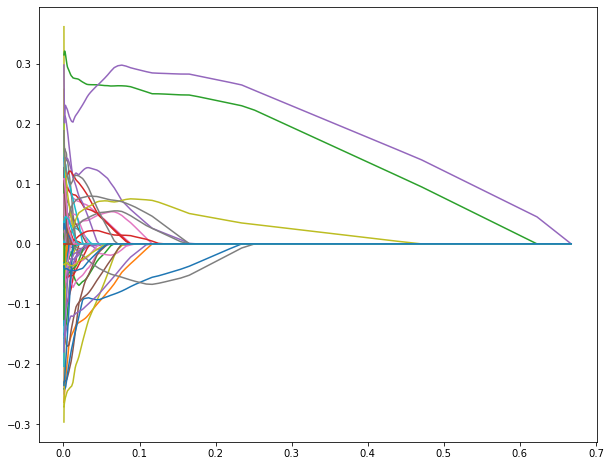

In [16]:
# compute the path
[alphas,weights,c] = Lasso2.path(X2_std, Y2_std.ravel(), max_iter=10000)

# plot the path
fig, ax = plt.subplots()
ax.plot(alphas, weights.T)
plt.show()

Compare the two charts. They look vastly different!


##### 3.4.2.1 Estimating the model (Own implementation)

**You can ignore section 3.4.2.1 and jump to the implementation with `statsmodels` in section 3.4.2.2.**

Let's again turn to the OLS model.

First, we have to extract the remaining features. 

In [17]:
# read out the set of remaining features

X2_reduced = X2[:,Lasso2.coef_ != 0]

We are now ready to define the regression object and to run the estimation. 

In [18]:
reg2 = OLS(Y2[:,None], X2_reduced)
reg2.estimate('standard')

Standard Errors computed using method: standard


,beta,se,t-statistic,p-value,CI - lower,CI - upper
0,-6.349894e-02,1.502865e-02,4.225191,2.387379e-05,-9.295456e-02,-0.034043
1,1.701069e-02,1.072553e-02,1.586001,1.127392e-01,-4.010954e-03,0.038032
2,-3.712182e-02,1.815486e-02,2.044732,4.088130e-02,-7.270468e-02,-0.001539
3,-5.903188e-03,1.256195e-02,0.469926,6.384077e-01,-3.052415e-02,0.018718
4,7.504676e-03,2.189590e-03,3.427434,6.093154e-04,3.213157e-03,0.011796
5,1.670353e-04,5.411411e-03,0.030867,9.753754e-01,-1.043914e-02,0.010773
6,5.361427e-07,4.107127e-07,1.305396,1.917580e-01,-2.688394e-07,0.000001
7,-7.975324e-05,1.179342e-04,0.676252,4.988808e-01,-3.109001e-04,0.000151
8,3.090829e-04,1.236413e-03,0.249984,8.026000e-01,-2.114241e-03,0.002732
9,1.182030e-04,7.066946e-04,0.167262,8.671640e-01,-1.266893e-03,0.001503


##### 3.4.2.2 Estimating the model (implementation with `statsmodels`)

Let's again turn to the OLS model.

First, we have to extract the remaining features. 

In [19]:
# read out the set of remaining features
X2_reduced = X2[:,Lasso2.coef_ != 0]

# run the regression
model = sm.OLS(Y2[:,None], X2_reduced)
results = model.fit()

# display output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.884
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              70.61
Date:                Tue, 02 Mar 2021   Prob (F-statistic):                   6.66e-134
Time:                        19:18:30   Log-Likelihood:                          1869.6
No. Observations:                 369   AIC:                                     -3667.
Df Residuals:                     333   BIC:                                     -3526.
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0635      0.015     -4.225      0.000      -0.093      -0.034
x2             0.0170      0.011      1.586      0.114      -0.004       0.038
x3            -0.0371      0.018     -2.045      0.042      -0.073      -0.001
x4            -0.0059      0.013     -0.470      0.639      -0.031       0.019
x5             0.0075      0.002      3.427      0.001       0.003       0.012
x6             0.0002      0.005      0.031      0.975      -0.010       0.011
x7          5.361e-07   4.11e-07      1.305      0.193   -2.72e-07    1.34e-06
x8         -7.975e-05      0.000     -0.676      0.499      -0.000       0.000
x9             0.0003      0.001      0.250      0.803      -0.002       0.003
x10            0.0001      0.001      0.167      0.867      -0.001       0.002
x11            0.0013      0.001      1.610      0.108      -0.000       0.003
x12        -6.888e-05      0.001     -0.099      0.921      -0.001       0.001
x13           -0.0072      0.003     -2.630      0.009      -0.013      -0.002
x14            0.0455      0.013      3.556      0.000       0.020       0.071
x15            0.0603      0.027      2.245      0.025       0.007       0.113
x16           -0.0292      0.009     -3.222      0.001      -0.047      -0.011
x17            0.0105      0.009      1.220      0.223      -0.006       0.027
x18           -0.1317      0.032     -4.142      0.000      -0.194      -0.069
x19            0.0122      0.004      2.854      0.005       0.004       0.021
x20           -0.0044      0.001     -3.350      0.001      -0.007      -0.002
x21           -0.3042      0.081     -3.756      0.000      -0.464      -0.145
x22           -0.0007      0.003     -0.226      0.821      -0.007       0.006
x23            0.0019      0.001      3.361      0.001       0.001       0.003
x24           -0.0010      0.001     -1.371      0.171      -0.002       0.000
x25        -6.974e-05    7.2e-05     -0.968      0.334      -0.000    7.19e-05
x26           -0.0157      0.004     -4.004      0.000      -0.023      -0.008
x27           -0.0021      0.007     -0.316      0.752      -0.015       0.011
x28            0.0220      0.020      1.075      0.283      -0.018       0.062
x29            0.0055      0.001      6.025      0.000       0.004       0.007
x30        -5.706e-05      0.002     -0.031      0.975      -0.004       0.004
x31            0.1361      0.047      2.913      0.004       0.044       0.228
x32            0.1090      0.031      3.532      0.000       0.048       0.170
x33           -0.0203      0.037     -0.544      0.587      -0.094       0.053
x34            0.0337      0.013      2.566      0.011       0.008       0.060
x35           -0.0026      0.003     -0.897      0.370      -

Notice, that this time one more feature is included in the active set. However, again not all the variables are statistically significant. Let us discuss this point in some detail.


### 4.0 Interpretation

* There is a fundamental difference between forecasting and regression. In forecasting we are not interested in the significance of variables, rather we are interested in predictions of an outcome! That said, in forecasting we are happy to nudge the bias-variance trade-off in our favor:

    * This is related to the concepts of over- and underfitting. Underfitting means that when we train a model on training data, but keep it way too simple, it does not generalize well. Essentially, we leave a lot of useful information unexploited. As an extreme case, imagine we just use a constant and essentially draw a straight line through the data. The bias, or in this case difference between the true values and the estimate (the line), is large. Overfitting on the other hand occurs when we make our model way to complex. As an extreme case, imagine that we had one dummy for each observation and thus hit every data point perfectly. In this case the variance of the prediction is very high and again the model does not generalize well. We simply take into account too much noise or information that is related to a single data point, but tells little about other data (see the two plots below for an illustration). 
    
    * Plainly said, in forecasting we are happy to get biased estimates, if they improve our forecasts! In his famous paper, Copas (1983) makes the observation that "the fit of a regression predictor to new data is nearly always worse than its fit to the original data." Lasso and other so-called shrinkage methods aim to fix this problem by introducing bias. As the coefficients are shrunk/biased towards zero, they will likely underestimate the population parameters and consequently differ from OLS. At the same time, this will reduce the variance and alleviate the overfitting problem! As long as the second effect is bigger than the first, Lasso will produce better out-of-sample predictions. Cross-validation helps us to choose the degree by how much we want to bias the estimates. In essence, it helps find the sweet spot where the bias-variance trade-off is optimized. 
    
    * This means that we do not care about statistical significance of a model coefficients! On the contrary, in regressions we want unbiased/consistent estimates of a model coefficients. The objective is thus completely different and using Lasso does not guarantee selecting variable that are statistically significant.

Further comments:

* In regression problems it might be useful to include variables as control variables even if they are not significant. This, e.g., avoids omitted variable biases. Usually we are only concerned with estimating the coefficient(s) of (a) certain specific variable(s) and thus the statistical significance of the control variables is not important. That said, as researchers we often have ideas about which variables should be included as control variables (for example by economic theory). Selection techniques such as Lasso cannot take these into account. We might hence be left with a set of variables that might seem counterintuitive after running model selection. While being automatic, these procedures thus do not take care of the thinking for us!

* In regression, the quantitative size of an estimate is also important. Besides the statistical significance we need to ask ourselves whether the estimate is quantitatively sizable enough to be considered economically significant!


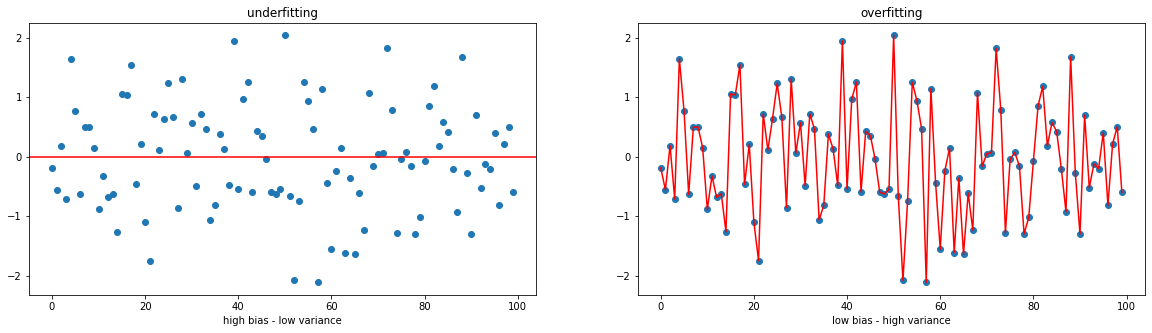

In [20]:
x = np.random.randn(100)

# plot the path
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(x, marker='o', linestyle='')
ax[0].axhline(y=0, color='r', linestyle='-')
ax[0].set_title('underfitting')
ax[0].set_xlabel('high bias - low variance')
ax[1].plot(x, marker='o', linestyle='')
ax[1].plot(x, color='r', linestyle='-')
ax[1].set_title('overfitting')
ax[1].set_xlabel('low bias - high variance')
plt.show()

## References
Copas, John B. "Regression, prediction and shrinkage." Journal of the Royal Statistical Society: Series B (Methodological) 45, no. 3 (1983): 311-335.